In [2]:
#Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score

from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

import random
import string
from datetime import date
random.seed(1)
import copy


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

c:\Users\SS5891\OneDrive - Hitachi Energy\Desktop\Intern\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

columns=['Customer Name','MVA','HV','Quantity','Sales Stage','Reason','Aging','Awarding period','Requested Bidding Date','Actual Bidding Date','Total Sales']
Values=[]
Stage=['Lost','Won','cancelled','Under Progress']
Reas=['Price','Poor Customer Service/Relationship','Delivery Delays','Technical issues','Incorrect Bid','DisQualified','Competitors','Unknown','Regular Customer']

for i in range(0,600):
  Row=[random.choice(list(string.ascii_uppercase)),random.randint(10,500),random.randint(10,800),
       random.randint(1,20),random.choice(Stage),
       random.choice(Reas),random.randint(-80,50),random.randint(30,60)]

  Values.append(Row)
  #print(Row)


In [4]:
sales_mill = np.random.lognormal(mean=2, sigma=0.5, size=600) * 1  # Sales in millions
sales_in_millions = np.round(sales_mill, 2)  # Round to 2 decimal places

In [5]:
award_date_range = pd.date_range(start="2016-01-01", end="2021-12-31")  # Full range of dates
Award_date_created= np.random.choice(award_date_range, size=600)  # Randomly sample with repetition
Award_date=sorted(Award_date_created)

In [6]:
Transformer_Sales=pd.DataFrame(Values,columns=columns[0:8])
Transformer_Sales['Total Sales']=sales_in_millions
Transformer_Sales['Award Date']=Award_date
Transformer_Sales.head()

,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Awarding period,Total Sales,Award Date
0,E,301,792,3,cancelled,Poor Customer Service/Relationship,46,54,8.15,2016-01-11
1,O,251,677,13,Won,Poor Customer Service/Relationship,44,30,11.38,2016-01-12
2,M,231,632,1,Under Progress,Incorrect Bid,-22,48,5.36,2016-01-14
3,D,471,335,1,Lost,Price,-78,60,6.77,2016-01-20
4,M,361,231,14,Lost,Regular Customer,-24,54,8.53,2016-01-25


In [7]:
Transformer_Sales['Requested Bidding Date']=Transformer_Sales['Award Date']- pd.to_timedelta(Transformer_Sales['Awarding period'], unit='D')
Transformer_Sales['Actual Bidding Date']=Transformer_Sales['Requested Bidding Date']- pd.to_timedelta(Transformer_Sales['Aging'], unit='D')
Transformer_Sales.drop('Awarding period',axis=1,inplace=True)
Transformer_Sales.head()

,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Total Sales,Award Date,Requested Bidding Date,Actual Bidding Date
0,E,301,792,3,cancelled,Poor Customer Service/Relationship,46,8.15,2016-01-11,2015-11-18,2015-10-03
1,O,251,677,13,Won,Poor Customer Service/Relationship,44,11.38,2016-01-12,2015-12-13,2015-10-30
2,M,231,632,1,Under Progress,Incorrect Bid,-22,5.36,2016-01-14,2015-11-27,2015-12-19
3,D,471,335,1,Lost,Price,-78,6.77,2016-01-20,2015-11-21,2016-02-07
4,M,361,231,14,Lost,Regular Customer,-24,8.53,2016-01-25,2015-12-02,2015-12-26


In [8]:
Transformer_Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Customer Name           600 non-null    object        
 1   MVA                     600 non-null    int64         
 2   HV                      600 non-null    int64         
 3   Quantity                600 non-null    int64         
 4   Sales Stage             600 non-null    object        
 5   Reason                  600 non-null    object        
 6   Aging                   600 non-null    int64         
 7   Total Sales             600 non-null    float64       
 8   Award Date              600 non-null    datetime64[ns]
 9   Requested Bidding Date  600 non-null    datetime64[ns]
 10  Actual Bidding Date     600 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(4), object(3)
memory usage: 51.7+ KB


In [9]:
Transformer_Sales['Requested Bidding Date']=pd.to_datetime(Transformer_Sales['Requested Bidding Date'])
Transformer_Sales['Actual Bidding Date']=pd.to_datetime(Transformer_Sales['Actual Bidding Date'])
Transformer_Sales['Award Date']=pd.to_datetime(Transformer_Sales['Award Date'])

In [10]:
Transformer_Sales.describe(include=np.number)

,MVA,HV,Quantity,Aging,Total Sales
count,600.000000,600.000000,600.000000,600.000000,600.000000
mean,258.668333,394.421667,10.435000,-12.631667,8.397800
std,140.434700,223.427790,5.721626,37.773192,4.343545
min,10.000000,13.000000,1.000000,-80.000000,1.330000
25%,139.750000,214.250000,5.000000,-43.250000,5.360000
50%,268.000000,379.000000,10.000000,-11.500000,7.490000
75%,380.000000,586.000000,15.000000,19.000000,10.237500
max,498.000000,800.000000,20.000000,50.000000,32.320000


In [11]:
def HV_binning(spec):
  if  12.0 <= spec <= 22.0 :
    return 'HV-1'
  elif 22 < spec <= 33 :
    return 'HV-2'
  elif 33 < spec <= 66 :
    return 'HV-3'
  elif 66 < spec <= 100 :
    return 'HV-4'
  elif 100 < spec <= 130 :
    return 'HV-5'
  elif 130 <= spec <= 200 :
    return 'HV-6'
  elif 200 <= spec <= 300 :
    return 'HV-7'
  elif 300 <= spec <= 450 :
    return 'HV-8'
  elif 450 <= spec <= 800 :
    return 'HV-9'

In [12]:
Transformer_Sales['HV_bins']=Transformer_Sales['HV'].apply(HV_binning)
Transformer_Sales.head()

,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Total Sales,Award Date,Requested Bidding Date,Actual Bidding Date,HV_bins
0,E,301,792,3,cancelled,Poor Customer Service/Relationship,46,8.15,2016-01-11,2015-11-18,2015-10-03,HV-9
1,O,251,677,13,Won,Poor Customer Service/Relationship,44,11.38,2016-01-12,2015-12-13,2015-10-30,HV-9
2,M,231,632,1,Under Progress,Incorrect Bid,-22,5.36,2016-01-14,2015-11-27,2015-12-19,HV-9
3,D,471,335,1,Lost,Price,-78,6.77,2016-01-20,2015-11-21,2016-02-07,HV-8
4,M,361,231,14,Lost,Regular Customer,-24,8.53,2016-01-25,2015-12-02,2015-12-26,HV-7


In [13]:
def MVA_binning(spec):
  if  11.0 <= spec <= 30.0 :
    return 'MVA-1'
  elif 30 < spec <= 60 :
    return 'MVA-2'
  elif 60 <= spec <= 80 :
    return 'MVA-3'
  elif 80 < spec <= 100 :
    return 'MVA-4'
  elif 100 < spec <= 150 :
    return 'MVA-5'
  elif 150 <= spec <= 200 :
    return 'MVA-6'
  elif 200 <= spec <= 400 :
    return 'MVA-7'
  elif spec >=400 :
    return 'MVA-8'

In [14]:
Transformer_Sales['MVA_bins']=Transformer_Sales['MVA'].apply(MVA_binning)
Transformer_Sales.head()

,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Total Sales,Award Date,Requested Bidding Date,Actual Bidding Date,HV_bins,MVA_bins
0,E,301,792,3,cancelled,Poor Customer Service/Relationship,46,8.15,2016-01-11,2015-11-18,2015-10-03,HV-9,MVA-7
1,O,251,677,13,Won,Poor Customer Service/Relationship,44,11.38,2016-01-12,2015-12-13,2015-10-30,HV-9,MVA-7
2,M,231,632,1,Under Progress,Incorrect Bid,-22,5.36,2016-01-14,2015-11-27,2015-12-19,HV-9,MVA-7
3,D,471,335,1,Lost,Price,-78,6.77,2016-01-20,2015-11-21,2016-02-07,HV-8,MVA-8
4,M,361,231,14,Lost,Regular Customer,-24,8.53,2016-01-25,2015-12-02,2015-12-26,HV-7,MVA-7


# **HIT RATE**

In [15]:
New_Data=copy.deepcopy(Transformer_Sales)

Customers=np.unique(New_Data['Customer Name'])

won_counts = []
lost_counts = []
hit_rates = []

for i in Customers:
    won_df = New_Data[(New_Data["Sales Stage"] == "Won") &
                      (New_Data['Customer Name'] == i)]["Sales Stage"]
    won_count = won_df.value_counts().iloc[0] if not won_df.empty else 0

    lost_df = New_Data[(New_Data["Sales Stage"] == "Lost") &
                       (New_Data['Customer Name'] == i)]["Sales Stage"]
    lost_count = lost_df.value_counts().iloc[0] if not lost_df.empty else 0

    hit_rate = (won_count / (won_count + lost_count)) * 100 if won_count + lost_count > 0 else 0

    won_counts.append(won_count)
    lost_counts.append(lost_count)
    hit_rates.append(hit_rate)


In [16]:
dict_list = list(zip(Customers,won_counts, lost_counts, hit_rates))

# Sort the list by the hit_rate (4th element in the tuple) in descending order
sorted_data = sorted(dict_list, key=lambda x: x[3], reverse=True)

In [17]:
Customers= [tup[0] for tup in sorted_data]
won_counts= [tup[1] for tup in sorted_data]
lost_counts=  [tup[2] for tup in sorted_data]
hit_rates=  [tup[3] for tup in sorted_data]

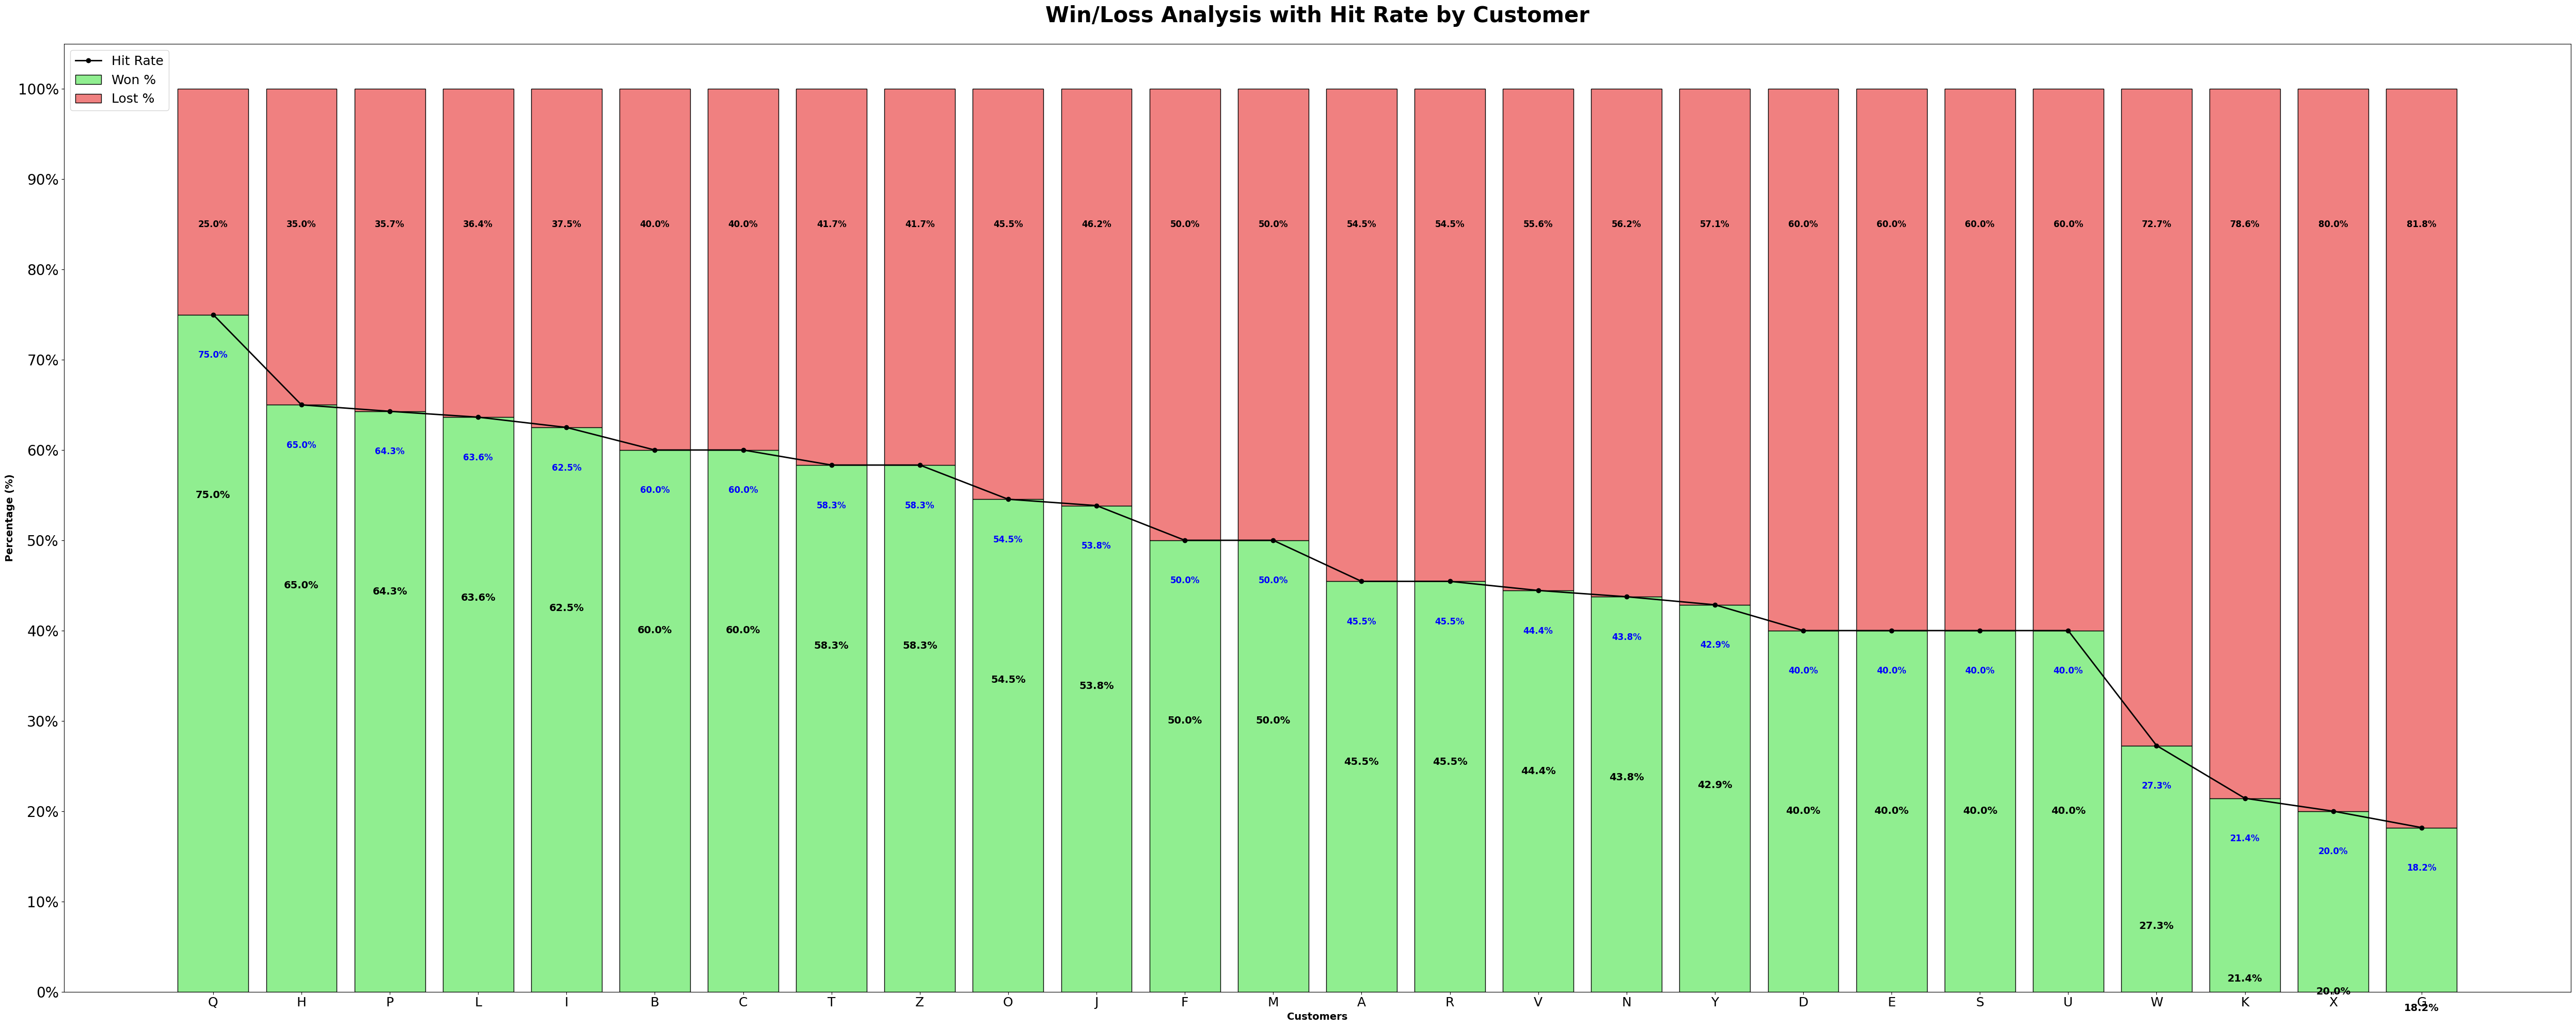

In [18]:
# Normalize the won and lost counts to percentages for stacked bar chart
total_counts = [won + lost for won, lost in zip(won_counts, lost_counts)]
won_percentages = [won / total * 100 if total != 0 else 0 for won, total in zip(won_counts, total_counts)]
lost_percentages = [lost / total * 100 if total != 0 else 0 for lost, total in zip(lost_counts, total_counts)]

# Set up the figure and axis with a larger size for readability
plt.figure(figsize=(50, 20))
x = np.arange(len(Customers))
bar_width = 6

# Create stacked bar chart for win/loss percentages
plt.bar(x, won_percentages, color='lightgreen', label='Won %', edgecolor='black')
plt.bar(x, lost_percentages, bottom=won_percentages, color='lightcoral', label='Lost %', edgecolor='black')

# Plot line chart for hit rates
plt.plot(x, hit_rates, color='black', marker='o', linestyle='-', linewidth=2, label='Hit Rate')

# Add text annotations for Won and Lost percentages
for i, (won, lost,rate) in enumerate(zip(won_percentages, lost_percentages,hit_rates)):
    plt.text(i, won  - 20 , f"{won:.1f}%", ha='center', va='center', color='black', fontweight='bold',fontsize=14)  # Won %
    plt.text(i, won + lost - 15, f"{lost:.1f}%", ha='center', va='center', color='black', fontweight='bold',fontsize=12)  # Lost %
    plt.text(i, rate -5, f"{rate:.1f}%", ha='center', va='bottom', color='blue', fontweight='bold',fontsize=12)


plt.xticks(x, Customers, fontsize=18)
plt.yticks(np.linspace(0, 100, 11), [f"{int(y)}%" for y in np.linspace(0, 100, 11)], fontsize=20)
plt.xlabel('Customers', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=14, fontweight='bold')
plt.title('Win/Loss Analysis with Hit Rate by Customer', fontsize=30, fontweight='bold', pad=30)
plt.legend(loc='upper left', fontsize=18)


plt.tight_layout()
plt.show()


In [19]:
New_Data.groupby("Sales Stage")["Reason"].value_counts()

Sales Stage     Reason                            
Lost            Price                                 21
                Technical issues                      20
                Competitors                           18
                Poor Customer Service/Relationship    18
                Regular Customer                      18
                Unknown                               17
                Incorrect Bid                         15
                DisQualified                          14
                Delivery Delays                       12
Under Progress  DisQualified                          21
                Technical issues                      20
                Delivery Delays                       19
                Competitors                           18
                Regular Customer                      16
                Unknown                               16
                Price                                 15
                Incorrect Bid        

# **Considering Hit Rate >30%**
                                                                
# **LOST**
    1.  Delivery Delay is the major reason for closing the bid. So we need to improve it from Factory end. (May be due to raw materials, Existing project, man power etc,.)
    2.  Technical issues may be we need to improve data quality  
    2.  Regular Customer lost order is more serious


**Solution**
   
    1. Unavailability of materials or factor being busy with other things.So we can consider this too
    2. To keep Price factor under control we can watch market for lesser Raw materials cost and stock them
    3. For existing customer, We need to focus on relationship, Service

# **WON**
    1.  Competitors is may be not upto our quality/pricing

**Needs Attention**

    1. Unknown reason need to explored with a survey conducted/ Feedback form to them and linking that to the data sysytem



In [20]:
Transformer_Sales_won=Transformer_Sales[Transformer_Sales['Sales Stage']=='Won']
Transformer_Sales_won.head()

,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Total Sales,Award Date,Requested Bidding Date,Actual Bidding Date,HV_bins,MVA_bins
1,O,251,677,13,Won,Poor Customer Service/Relationship,44,11.38,2016-01-12,2015-12-13,2015-10-30,HV-9,MVA-7
5,O,490,517,18,Won,DisQualified,-21,6.79,2016-01-26,2015-12-06,2015-12-27,HV-9,MVA-8
13,H,16,799,7,Won,Competitors,8,4.82,2016-02-20,2015-12-22,2015-12-14,HV-9,MVA-1
18,H,335,191,18,Won,Poor Customer Service/Relationship,-15,7.91,2016-03-02,2016-01-31,2016-02-15,HV-6,MVA-7
26,Z,365,538,15,Won,Regular Customer,-73,6.94,2016-03-18,2016-02-05,2016-04-18,HV-9,MVA-7


# **RFM and clustering**

In [21]:
today = pd.to_datetime('today')

#  Recency, Frequency, and Monetary ---- (RFM) 
rfm_df = Transformer_Sales_won.groupby('Customer Name').agg(
    Recency=('Award Date', lambda x: (today - x.max()).days),  # Days since last purchase
    Frequency=('Award Date', 'count'),  # Number of transactions
    Monetary=('Total Sales', 'sum')  # Total amount spent
).reset_index()

# Check the RFM DataFrame
print(rfm_df.head())


  Customer Name  Recency  Frequency  Monetary
0             A     1566          5     55.74
1             B     1220          6     50.75
2             C     1315          3     32.53
3             D     1300          6     76.82
4             E     1272          4     40.77


<Figure size 1000x600 with 0 Axes>

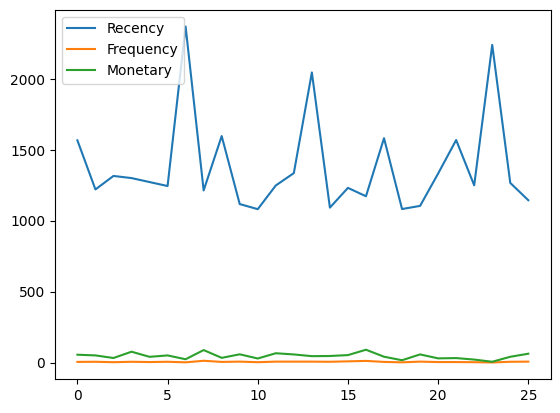

In [65]:
plt.figure(figsize=(10, 6))
rfm_df.plot()
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

rfm_df_kmeans=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_scaled_kmeans = scaler.fit_transform(rfm_df_kmeans[['Recency', 'Frequency', 'Monetary']])

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df_kmeans['Cluster'] = kmeans.fit_predict(rfm_scaled_kmeans)
rfm_df_kmeans.head()

,Customer Name,Recency,Frequency,Monetary,Cluster
0,A,1566,5,55.74,1
1,B,1220,6,50.75,0
2,C,1315,3,32.53,4
3,D,1300,6,76.82,0
4,E,1272,4,40.77,4


In [23]:
rfm_df_kmeans.Cluster.value_counts()


Cluster
0    11
4     6
1     5
2     2
3     2
Name: count, dtype: int64

<Axes: xlabel='Recency', ylabel='Monetary'>

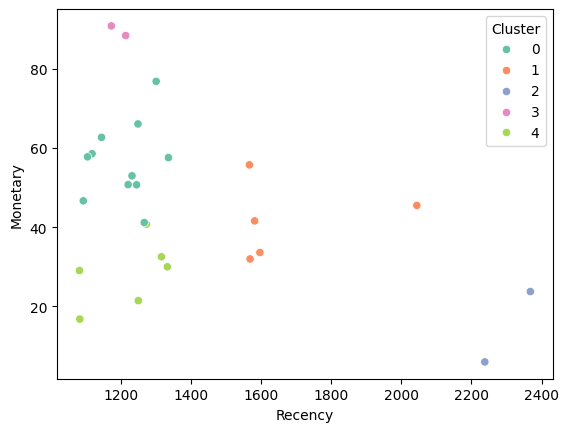

In [24]:
sns.scatterplot(data=rfm_df_kmeans, x='Recency', y='Monetary', hue='Cluster', palette='Set2')

In [25]:

cluster_summary = rfm_df_kmeans.groupby('Cluster').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean')
).reset_index()

print(cluster_summary)

   Cluster      Recency  Frequency   Monetary
0        0  1209.181818   6.727273  56.520909
1        1  1671.000000   5.200000  41.684000
2        2  2303.000000   1.500000  14.865000
3        3  1192.500000  12.500000  89.605000
4        4  1221.833333   3.166667  28.433333


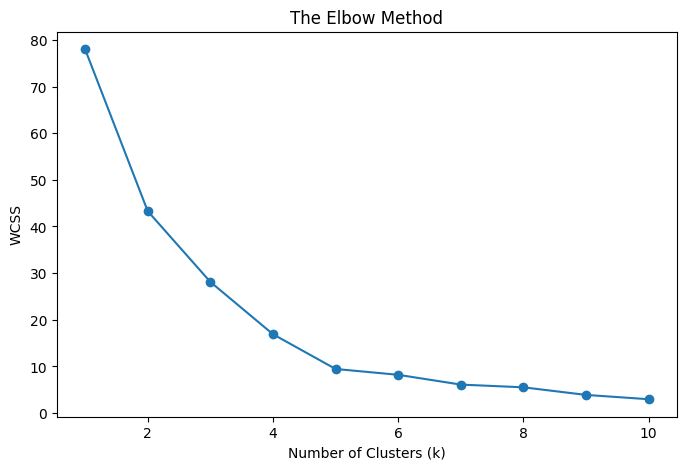

In [26]:
# k values
k_range = range(1, 11)

wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled_kmeans)  
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()


# k=5 the wcss stops decreasing

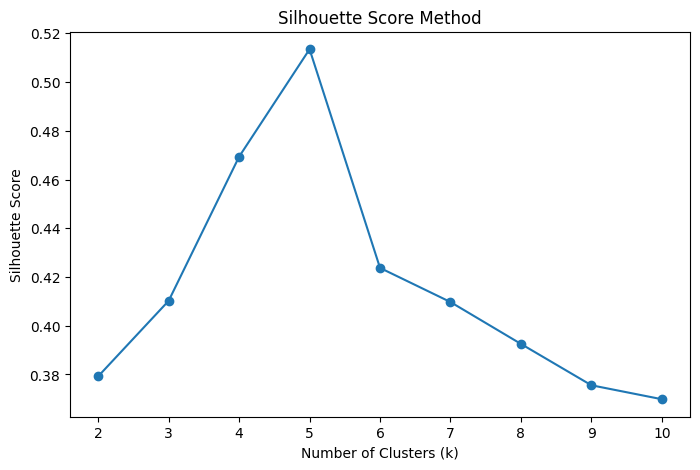

In [27]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_range[1:]:  # Silhouette is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled_kmeans)  # Replace 'data' with your features
    score = silhouette_score(rfm_scaled_kmeans, labels)
    silhouette_scores.append(score)

# Plot Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


# k=5 has highest silhoutte score

In [28]:
# Group the RFM data by cluster and calculate the mean values


cluster_summary = rfm_df_kmeans.groupby('Cluster').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean')
).reset_index()

print(cluster_summary)


   Cluster      Recency  Frequency   Monetary
0        0  1209.181818   6.727273  56.520909
1        1  1671.000000   5.200000  41.684000
2        2  2303.000000   1.500000  14.865000
3        3  1192.500000  12.500000  89.605000
4        4  1221.833333   3.166667  28.433333


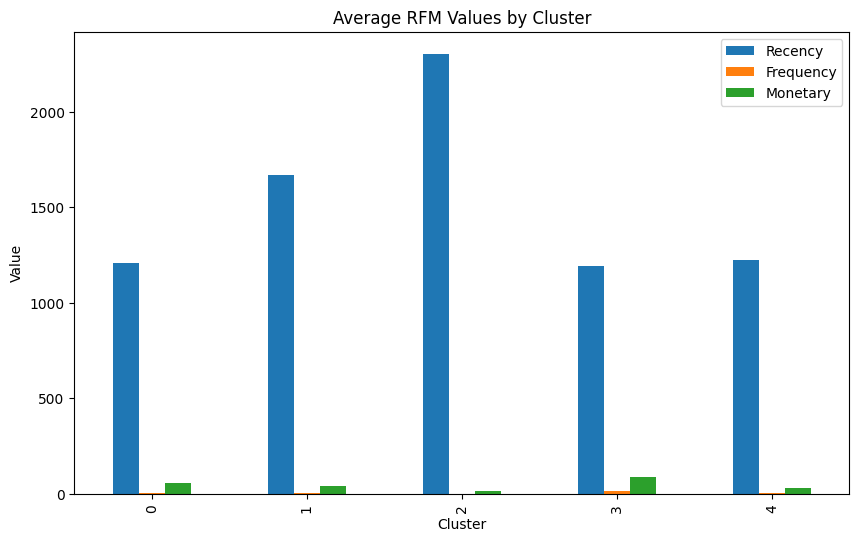

In [29]:
cluster_summary.plot(kind='bar', x='Cluster', figsize=(10, 6))
plt.title('Average RFM Values by Cluster')
plt.ylabel('Value')
plt.show()

In [30]:
#cluster 3
cluster_3_customers = rfm_df_kmeans[rfm_df_kmeans['Cluster'] == 3]

print(cluster_3_customers)


   Customer Name  Recency  Frequency  Monetary  Cluster
7              H     1213         13     88.39        3
16             Q     1172         12     90.82        3


In [ ]:
Transformer_Sales_won[Transformer_Sales_won['Customer Name']=='H']


,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Total Sales,Award Date,Requested Bidding Date,Actual Bidding Date,HV_bins,MVA_bins
13,H,16,799,7,Won,Competitors,8,4.82,2016-02-20,2015-12-22,2015-12-14,HV-9,MVA-1
18,H,335,191,18,Won,Poor Customer Service/Relationship,-15,7.91,2016-03-02,2016-01-31,2016-02-15,HV-6,MVA-7
106,H,263,470,13,Won,Technical issues,-20,5.70,2017-01-31,2016-12-06,2016-12-26,HV-9,MVA-7
179,H,333,319,18,Won,Price,50,4.20,2017-08-30,2017-07-28,2017-06-08,HV-8,MVA-7
206,H,48,559,18,Won,Delivery Delays,16,11.43,2017-12-18,2017-10-31,2017-10-15,HV-9,MVA-2
272,H,321,53,20,Won,Technical issues,-18,7.95,2018-08-01,2018-06-10,2018-06-28,HV-3,MVA-7
293,H,435,511,11,Won,Poor Customer Service/Relationship,-19,4.45,2018-11-01,2018-09-30,2018-10-19,HV-9,MVA-8
309,H,400,155,5,Won,Price,-39,5.53,2018-12-29,2018-11-14,2018-12-23,HV-6,MVA-7
352,H,170,416,13,Won,Price,19,6.65,2019-06-06,2019-04-17,2019-03-29,HV-8,MVA-6
460,H,193,565,18,Won,Incorrect Bid,-75,2.54,2020-08-17,2020-06-21,2020-09-04,HV-9,MVA-6


In [32]:
# Merge RFM metrics with original dataset
RFM_combined = Transformer_Sales_won.merge(rfm_df_kmeans[['Customer Name', 'Recency', 'Frequency', 'Monetary']], on='Customer Name')
RFM_combined

,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Total Sales,Award Date,Requested Bidding Date,Actual Bidding Date,HV_bins,MVA_bins,Recency,Frequency,Monetary
0,O,251,677,13,Won,Poor Customer Service/Relationship,44,11.38,2016-01-12,2015-12-13,2015-10-30,HV-9,MVA-7,1092,6,46.66
1,O,490,517,18,Won,DisQualified,-21,6.79,2016-01-26,2015-12-06,2015-12-27,HV-9,MVA-8,1092,6,46.66
2,H,16,799,7,Won,Competitors,8,4.82,2016-02-20,2015-12-22,2015-12-14,HV-9,MVA-1,1213,13,88.39
3,H,335,191,18,Won,Poor Customer Service/Relationship,-15,7.91,2016-03-02,2016-01-31,2016-02-15,HV-6,MVA-7,1213,13,88.39
4,Z,365,538,15,Won,Regular Customer,-73,6.94,2016-03-18,2016-02-05,2016-04-18,HV-9,MVA-7,1144,7,62.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,T,365,759,11,Won,Delivery Delays,-45,8.78,2021-12-02,2021-10-14,2021-11-28,HV-9,MVA-7,1104,7,57.76
143,O,189,309,16,Won,Incorrect Bid,-78,8.34,2021-12-07,2021-10-29,2022-01-15,HV-8,MVA-6,1092,6,46.66
144,O,11,662,8,Won,Competitors,19,5.77,2021-12-14,2021-11-07,2021-10-19,HV-9,MVA-1,1092,6,46.66
145,S,446,642,9,Won,Technical issues,-39,7.54,2021-12-24,2021-11-22,2021-12-31,HV-9,MVA-8,1082,2,16.80


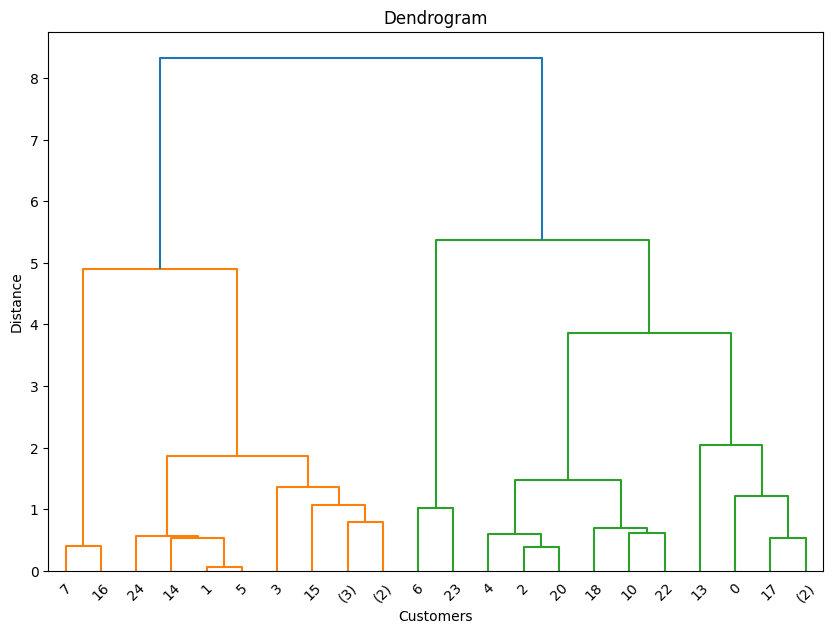

In [33]:
#rfm_scaled_kmeans

from sklearn.cluster import AgglomerativeClustering  
from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as shc 
from scipy.cluster.hierarchy import dendrogram, linkage

# Hierarchical clustering
# Create a dendrogram


rfm_agglo=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_scaled_agglo = scaler.fit_transform(rfm_agglo[['Recency', 'Frequency', 'Monetary']])


linked = linkage(rfm_scaled_agglo, method='ward')  # Ward's method
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='level',p=5)  # Show top levels
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.show()

# Fit Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
rfm_agglo['Cluster'] = hc.fit_predict(rfm_scaled_agglo)



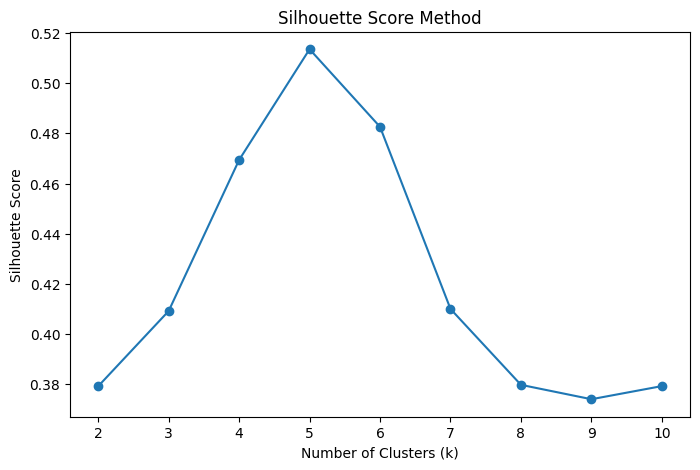

In [34]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_range[1:]:  # Silhouette is undefined for k=1
    hc = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    labels = hc.fit_predict(rfm_scaled_agglo)
    score = silhouette_score(rfm_scaled_agglo, labels)
    silhouette_scores.append(score)

# Plot Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [35]:
rfm_agglo.Cluster.value_counts()

Cluster
1    11
4     6
0     5
2     2
3     2
Name: count, dtype: int64

In [36]:
cluster_3_customers = rfm_agglo[rfm_agglo['Cluster'] == 3]

print(cluster_3_customers)


   Customer Name  Recency  Frequency  Monetary  Cluster
7              H     1213         13     88.39        3
16             Q     1172         12     90.82        3


   Cluster      Recency  Frequency   Monetary
0        0  1671.000000   5.200000  41.684000
1        1  1209.181818   6.727273  56.520909
2        2  2303.000000   1.500000  14.865000
3        3  1192.500000  12.500000  89.605000
4        4  1221.833333   3.166667  28.433333


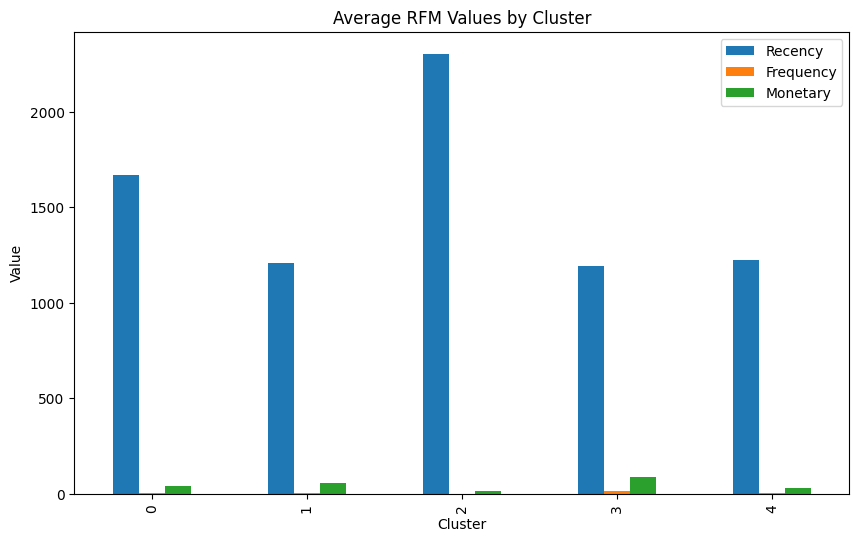

In [37]:

cluster_summary = rfm_agglo.groupby('Cluster').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean')
).reset_index()

print(cluster_summary)

cluster_summary.plot(kind='bar', x='Cluster', figsize=(10, 6))
plt.title('Average RFM Values by Cluster')
plt.ylabel('Value')
plt.show()

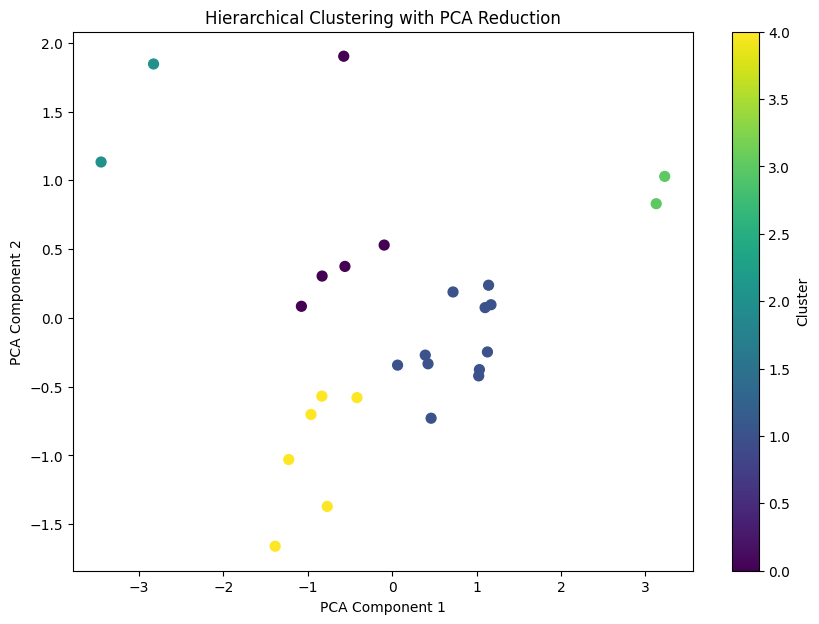

In [38]:
from sklearn.decomposition import PCA

# Reduce data to 2D using PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(rfm_scaled_agglo)

#print(reduced_data)

# Plot the data points, colored by the cluster
plt.figure(figsize=(10, 7))

#reduced_data = np.array(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=rfm_agglo['Cluster'], cmap='viridis', s=50)
plt.title('Hierarchical Clustering with PCA Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [39]:

# Explained variance ratio
print("\nExplained variance ratio of each component:")
pca.explained_variance_ratio_



Explained variance ratio of each component:


array([0.72802831, 0.24041615])

Silhouette Score: 0.5730300497501342
9


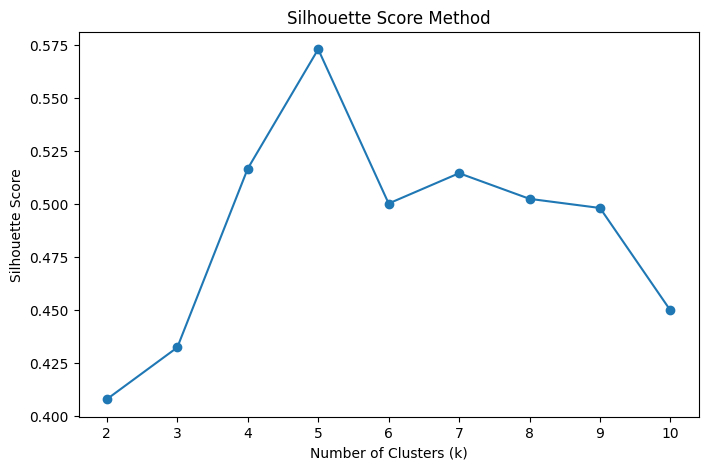

In [40]:
k_range = range(1, 11)

pca = PCA(n_components=2) 
reduced_data_90 = pca.fit_transform(rfm_scaled_agglo)

silhouette_scores=[]

# Cluster using KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_90 = kmeans.fit_predict(reduced_data_90)

# Evaluate Silhouette Score
silhouette_90 = silhouette_score(reduced_data_90, clusters_90)
print(f"Silhouette Score: {silhouette_90}")

for k in k_range[1:]:  # Silhouette is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters= kmeans.fit_predict(reduced_data_90)
    score = silhouette_score(reduced_data_90, clusters)
    silhouette_scores.append(score)

print(len(silhouette_scores))
# Plot Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()



Number of clusters: 2
Number of noise points: 11
0.2326439497817634


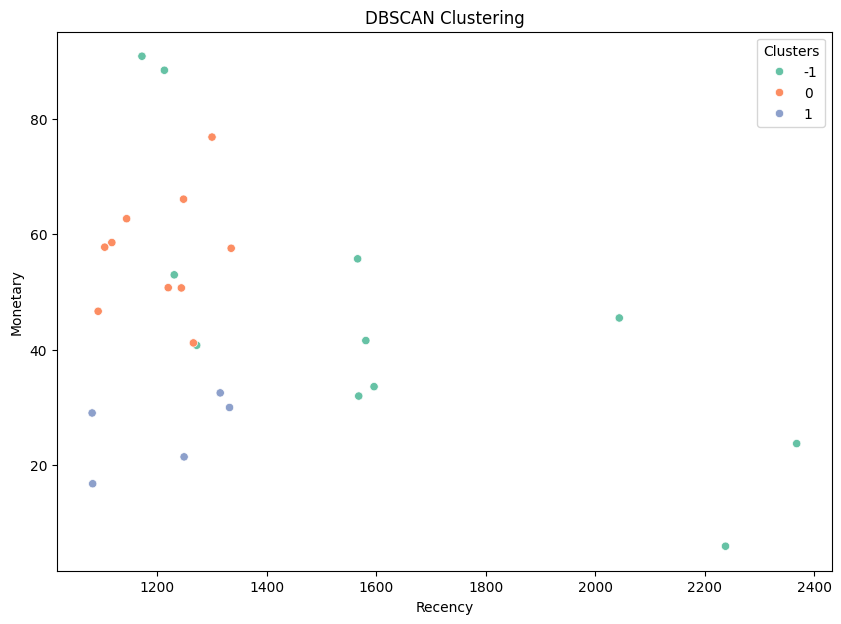

In [41]:
from sklearn.cluster import DBSCAN


rfm_dbscan=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_dbscan_scaled = scaler.fit_transform(rfm_dbscan[['Recency', 'Frequency', 'Monetary']])\

dbscan=DBSCAN(eps=0.7,min_samples=5)
dbscan_label=dbscan.fit_predict(rfm_dbscan_scaled)

rfm_dbscan['Clusters']=dbscan_label

# Count clusters
n_clusters = len(set(dbscan_label)) - (1 if -1 in dbscan_label else 0)
n_noise = list(dbscan_label).count(-1)


print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(silhouette_score(rfm_dbscan_scaled, rfm_dbscan['Clusters']))

# Plot DBSCAN results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=rfm_dbscan, x='Recency', y='Monetary', hue='Clusters', palette='Set2')
plt.title('DBSCAN Clustering')
plt.show()

In [42]:
rfm_dbscan.Clusters.value_counts()

Clusters
-1    11
 0    10
 1     5
Name: count, dtype: int64

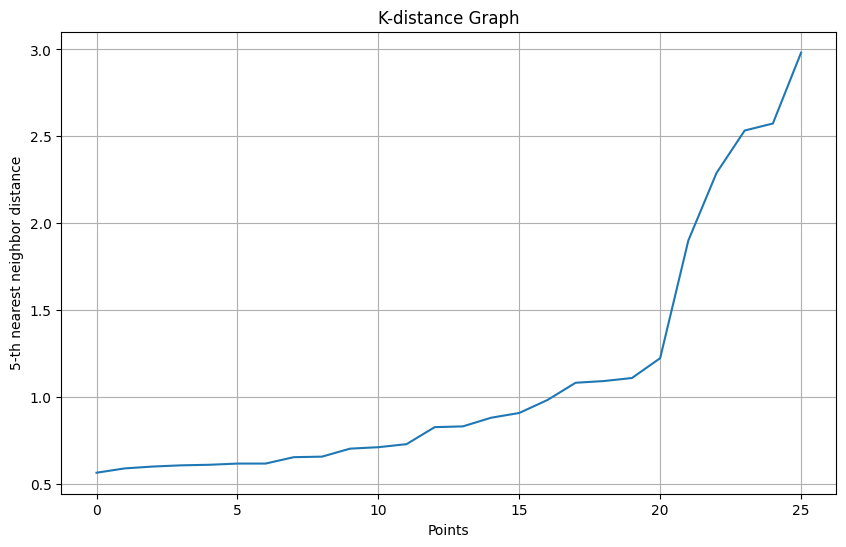

In [43]:
# Function to plot k-distance graph

from sklearn.neighbors import NearestNeighbors  


def plot_k_distance_graph(X, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title('K-distance Graph')
    plt.grid()
    plt.show()

# Plot k-distance graph
plot_k_distance_graph(rfm_dbscan_scaled, k=5)

In [44]:
eps = 1.2  #  epsilon from graph above sharp change
#min_samples_values =range [5, 10, 15, 20]  # Different values to test

best_score = -1
best_min_samples = None

for min_samples in range(2,21):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(rfm_dbscan_scaled)
    
    # Ignore noise points for silhouette score calculation
    if len(set(labels)) > 1:
        score = silhouette_score(rfm_dbscan_scaled, labels)
        if score > best_score:
            best_score = score
            best_min_samples = min_samples

print(f"Best min_samples: {best_min_samples} with silhouette score: {best_score}")

Best min_samples: 3 with silhouette score: 0.4393280382505335


Number of clusters: 3
Number of noise points: 1
0.4325098818913504


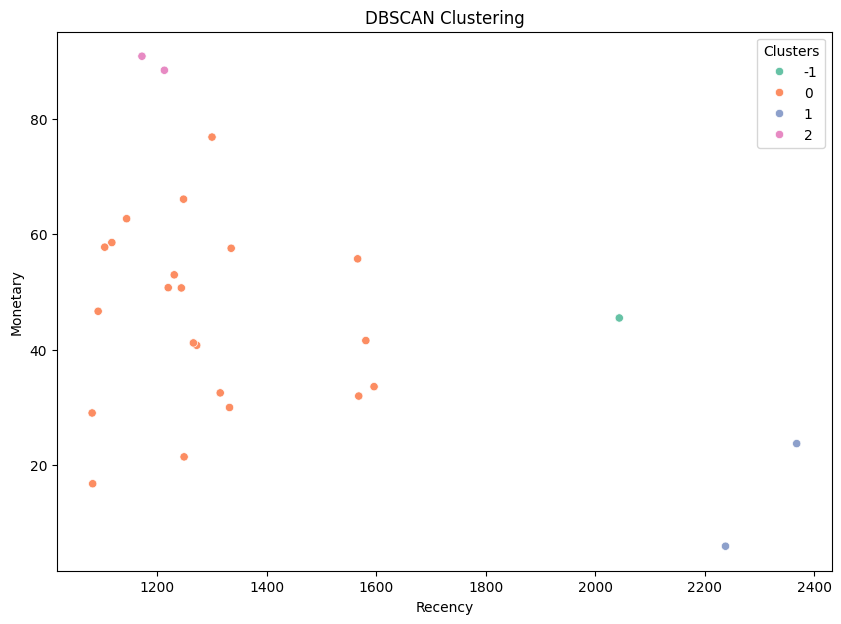

In [45]:
from sklearn.cluster import DBSCAN


rfm_dbscan=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_dbscan_scaled = scaler.fit_transform(rfm_dbscan[['Recency', 'Frequency', 'Monetary']])

dbscan=DBSCAN(eps=1.2,min_samples=2)
dbscan_label=dbscan.fit_predict(rfm_dbscan_scaled)

rfm_dbscan['Clusters']=dbscan_label

# Count clusters
n_clusters = len(set(dbscan_label)) - (1 if -1 in dbscan_label else 0)
n_noise = list(dbscan_label).count(-1)


print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(silhouette_score(rfm_dbscan_scaled, rfm_dbscan['Clusters']))

# Plot DBSCAN results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=rfm_dbscan, x='Recency', y='Monetary', hue='Clusters', palette='Set2')
plt.title('DBSCAN Clustering')
plt.show()

Number of clusters: 3
Number of noise points: 1
0.45777338607936546


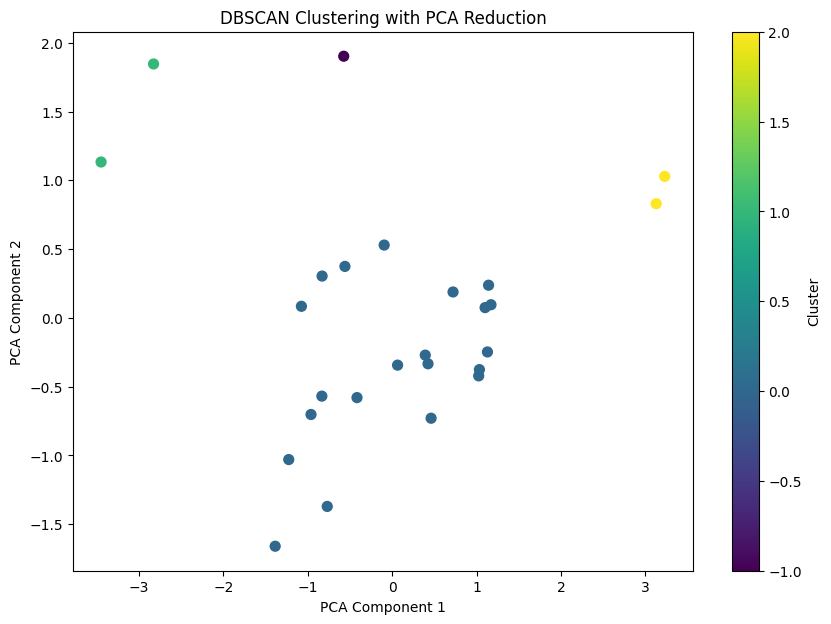

In [46]:

rfm_dbscan=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_dbscan_scaled = scaler.fit_transform(rfm_dbscan[['Recency', 'Frequency', 'Monetary']])


pca = PCA(n_components=0.9)
reduced_data = pca.fit_transform(rfm_dbscan_scaled)

#print(reduced_data)


dbscan=DBSCAN(eps=1.2,min_samples=2)
dbscan_label=dbscan.fit_predict(reduced_data)

rfm_dbscan['Clusters']=dbscan_label

# Count clusters
n_clusters = len(set(dbscan_label)) - (1 if -1 in dbscan_label else 0)
n_noise = list(dbscan_label).count(-1)


print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(silhouette_score(reduced_data, dbscan_label))


# Plot the data points, colored by the cluster
plt.figure(figsize=(10, 7))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=rfm_dbscan['Clusters'], cmap='viridis', s=50)
plt.title('DBSCAN Clustering with PCA Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [47]:

# Explained variance ratio
print("\nExplained variance ratio of each component:")
pca.explained_variance_ratio_



Explained variance ratio of each component:


array([0.72802831, 0.24041615])

0.4734528606889512


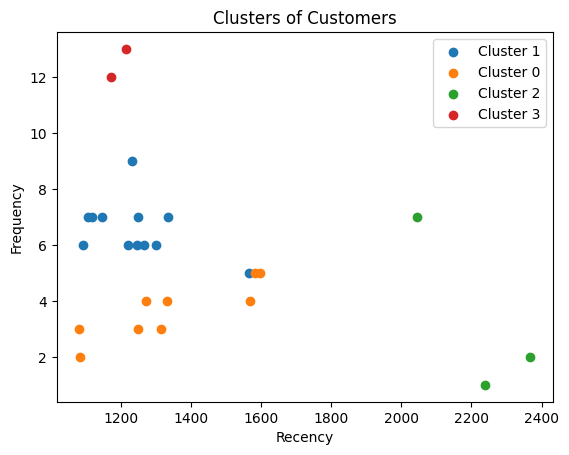

In [48]:
from sklearn.mixture import GaussianMixture


rfm_gmm=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_gmm_scaled = scaler.fit_transform(rfm_gmm[['Recency', 'Frequency', 'Monetary']])


gmm = GaussianMixture(n_components=4)
gmm.fit(rfm_gmm_scaled)

#predictions from gmm
gmm_labels = gmm.predict(rfm_gmm_scaled)
frame = pd.DataFrame(rfm_gmm)
frame['cluster'] = gmm_labels
frame.columns = ['	Customer Name','Recency', 'Frequency', 'Monetary','cluster']


print(silhouette_score(rfm_gmm_scaled, gmm_labels))
cluster_count=frame['cluster'].unique()

# Plotting clusters
for k in cluster_count:
    data = frame[frame["cluster"] == k]
    plt.scatter(data["Recency"], data["Frequency"], label=f'Cluster {k}')

plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Clusters of Customers')
plt.legend()
plt.show()

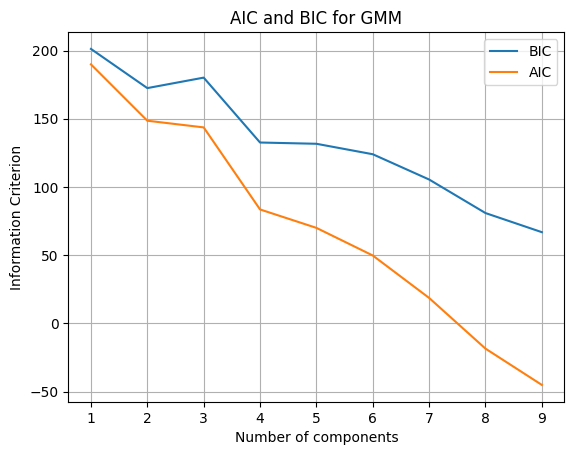

In [49]:
rfm_gmm=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_gmm_scaled = scaler.fit_transform(rfm_gmm[['Recency', 'Frequency', 'Monetary']])


n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(rfm_gmm_scaled) for n in n_components]

plt.plot(n_components, [m.bic(rfm_gmm_scaled) for m in models], label='BIC')
plt.plot(n_components, [m.aic(rfm_gmm_scaled) for m in models], label='AIC')
plt.grid(axis='both')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.legend(loc='best')
plt.title('AIC and BIC for GMM')
plt.show()

0.3646290424587508


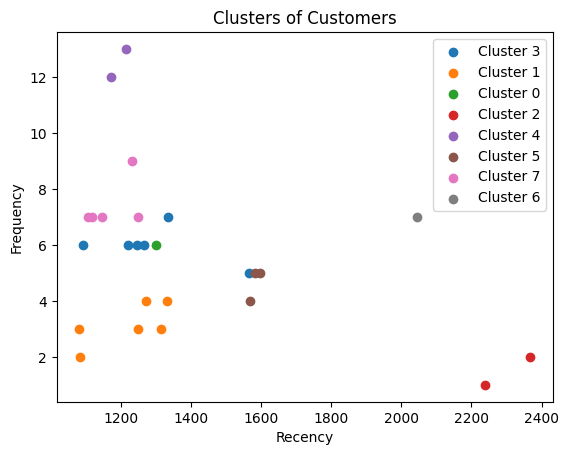

In [50]:
from sklearn.mixture import GaussianMixture


rfm_gmm=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
rfm_gmm_scaled = scaler.fit_transform(rfm_gmm[['Recency', 'Frequency', 'Monetary']])


gmm = GaussianMixture(n_components=8)
gmm.fit(rfm_gmm_scaled)

#predictions from gmm
gmm_labels = gmm.predict(rfm_gmm_scaled)
frame = pd.DataFrame(rfm_gmm)
frame['cluster'] = gmm_labels
frame.columns = ['	Customer Name','Recency', 'Frequency', 'Monetary','cluster']


print(silhouette_score(rfm_gmm_scaled, gmm_labels))
cluster_count=frame['cluster'].unique()

# Plotting clusters
for k in cluster_count:
    data = frame[frame["cluster"] == k]
    plt.scatter(data["Recency"], data["Frequency"], label=f'Cluster {k}')

plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Clusters of Customers')
plt.legend()
plt.show()

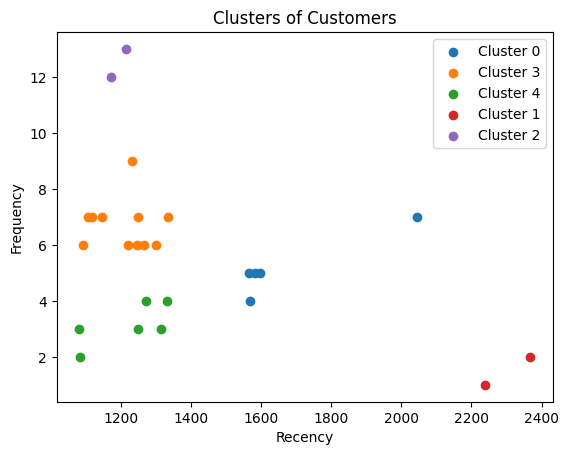

0.5134967999300764
Test Accuracy:  {0.5}
Train Accuracy:  {0.95}


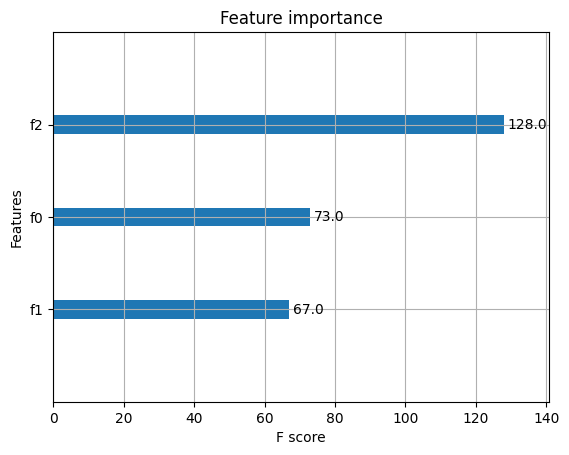

In [51]:
# Cluster-Based Ensemble Learning
# K Means clustering followed by separate XGBoost


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



xgb=copy.deepcopy(rfm_df)

# Normalize data
scaler = StandardScaler()
xgb_scaled = scaler.fit_transform(xgb[['Recency', 'Frequency', 'Monetary']])


# Clustering
kmeans = KMeans(n_clusters=5, random_state=24)
clusters = kmeans.fit_predict(xgb_scaled)


# Add cluster labels as a feature
xgb['cluster'] = clusters

cluster_count=xgb['cluster'].unique()

# Plotting clusters
for k in cluster_count:
    data = xgb[xgb["cluster"] == k]
    plt.scatter(data["Recency"], data["Frequency"], label=f'Cluster {k}')

plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Clusters of Customers')
plt.legend()
plt.show()

print(silhouette_score(xgb_scaled,xgb['cluster']))



X=xgb_scaled
y=xgb['cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: ',{accuracy})

# Predictions
y_train_pred = xgb.predict(X_train)

# Evaluate
accuracy = accuracy_score(y_train, y_train_pred)
print(f'Train Accuracy: ',{accuracy})


# Feature importance
from xgboost import plot_importance
plot_importance(xgb)
plt.show()

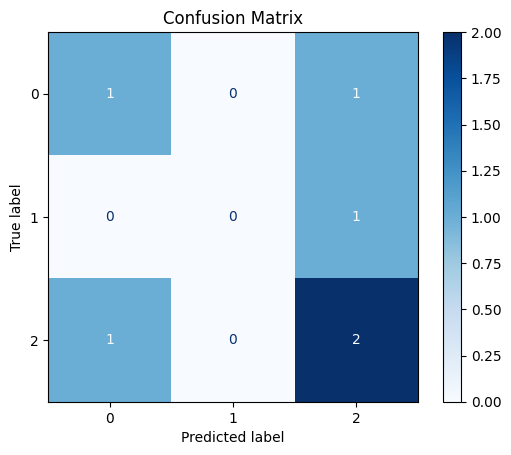

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**Customer Life time Analysis**

In [53]:
Transformer_Sales_won.head()

,Customer Name,MVA,HV,Quantity,Sales Stage,Reason,Aging,Total Sales,Award Date,Requested Bidding Date,Actual Bidding Date,HV_bins,MVA_bins
1,O,251,677,13,Won,Poor Customer Service/Relationship,44,11.38,2016-01-12,2015-12-13,2015-10-30,HV-9,MVA-7
5,O,490,517,18,Won,DisQualified,-21,6.79,2016-01-26,2015-12-06,2015-12-27,HV-9,MVA-8
13,H,16,799,7,Won,Competitors,8,4.82,2016-02-20,2015-12-22,2015-12-14,HV-9,MVA-1
18,H,335,191,18,Won,Poor Customer Service/Relationship,-15,7.91,2016-03-02,2016-01-31,2016-02-15,HV-6,MVA-7
26,Z,365,538,15,Won,Regular Customer,-73,6.94,2016-03-18,2016-02-05,2016-04-18,HV-9,MVA-7


In [57]:
today = pd.to_datetime('today')


#  Recency, Frequency, and Monetary ---- (RFM) 
rfm_Month = Transformer_Sales_won.groupby('Customer Name').agg(
    Month=('Award Date', lambda x: x.min().month),  # Days since last purchase
    Frequency=('Award Date', 'count'),  # Number of transactions
    Monetary=('Total Sales', 'sum')  # Total amount spent
).reset_index()

# Check the RFM DataFrame
print(rfm_Month.head())


  Customer Name  Month  Frequency  Monetary
0             A      8          5     55.74
1             B      5          6     50.75
2             C     10          3     32.53
3             D      9          6     76.82
4             E      3          4     40.77


<Axes: >

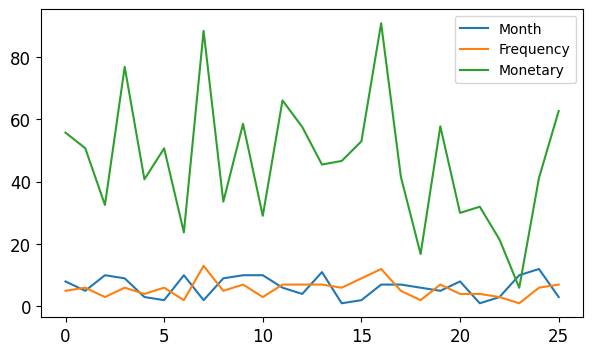

In [66]:
rfm_Month.plot(figsize=(7,4),fontsize=12)

In [56]:
profit_margin=0.05
CLV_Monthly={}

for i in range(1,13):  # for all months
    customers=rfm_Month[rfm_Month['Month']==i]
    Avg_sales=customers['Monetary'].mean()
    Purch_freq=customers['Frequency'].mean()
    #print(customers)
    Retention_rate=0 if customers.shape[0]==0 else customers[customers['Frequency']>1].shape[0]/customers.shape[0]
    #print('R',Retention_rate)
    churn=1-Retention_rate
    #print(churn,' dd' , Avg_sales*Purch_freq)
    CLV=0 if churn==0 else (Avg_sales*Purch_freq/churn) * profit_margin
    #print('c',CLV)
    CLV_Monthly[i]=CLV

CLV_Monthly


{1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 23.97920000000001,
 11: 0,
 12: 0}